# 프로젝트: House Price Prediction    
* 목표는 주택 가격 예측하는 것!

## 0. 환경 세팅

### Random Seed 고정    
랜덤 시드를 고정해줌으로서 같은 결과를 볼 수 있도록 해줍니다. 랜덤 시드를 고정하는 건 항상 같은 수를 내놓는다기 보다는 항상 같은 랜덤 패턴을 가진다고 생각하시면 됩니다. 예를 들어서 컴퓨터가 랜덤하게 1->2->3을 내놓는 패턴이 랜덤 시드 1이라면, 3->2->1 식의 패턴은 랜덤 시드 2 이런 식의 패턴이 동일하게 간다는 점입니다. 

In [98]:
import random
import numpy as np 
import tensorflow as tf
import os

# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
random_state = 3854 # 11, 2020, 3450 등 여러 파라미터를 통해 random_seed 결정
set_seeds(random_state)

seed = 3854일때, submission_lgbm_RMSLE_0.16403507171889764.csv <br>
seed = 3450일때, submission_lgbm_RMSLE_0.16579509411716917.csv <br>
seed = 2020일때, submission_lgbm_RMSLE_0.16625573978835373.csv <br>
seed = 11일때, submission_lgbm_RMSLE_0.16640884152286348.csv <br>

### 필요 라이브러리 import 

In [167]:
import warnings
warnings.filterwarnings("ignore")

# 디렉토리, 파일 시스템 관련 라이브러리 
import os
from os.path import join

import pandas as pd
import numpy as np

# 시각화 라이브러리 
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 데이터셋 관련 라이브러리 
from sklearn.model_selection import train_test_split

# 학습 모델 라이브러리 
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 검증을 위한 라잉브러리 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import time 
import datetime

### 디렉토리 설정 및 데이터 불러오기

* [os.getcwd](http://pythonstudy.xyz/python/article/507-%ED%8C%8C%EC%9D%BC%EA%B3%BC-%EB%94%94%EB%A0%89%ED%86%A0%EB%A6%AC): 현재 Jupyternotebook이 있는 디렉토리 경로 

In [168]:
!pwd # 현재 경로 

/home/aiffel-dj19/github/Exploration/Regression_price_prediction


In [169]:
os.getcwd() # os 라이브러리를 활용한 현재 경로 

'/home/aiffel-dj19/github/Exploration/Regression_price_prediction'

* train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
* test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
* sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

In [211]:
data_path = os.path.join(os.getenv("HOME"), 'aiffel/kaggle_kakr_housing/data') # '/' 안해줘도 됨 
train_data_path = join(data_path, 'train.csv')
test_data_path = join(data_path, 'test.csv')

print(train_data_path)
print(test_data_path)

/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다. <br>
pandas는 dataframe으로 데이터를 분석하기에 매우 유용한 라이브러리입니다. <br>
* 참고 링크: pandas? [pandas를 똑똑하게 쓰는 다이어트 전략](https://drive.google.com/file/d/12faqaslFIF-Sg_sU3jeGyauW5ClRqS8D/view)
---

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
**3. price : 타겟 변수인 집의 가격=> 종속 변수에 해당하고, 나머지는 독립 변수** 

4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
**18. lat : 위도**
**19. long : 경도**

20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

* baseline에서 tuning 해줬을 때, iters = 1000, depth = 10, rmsle = 0.164035
    * lat, long이 중요한 feature로 나타났습니다. 
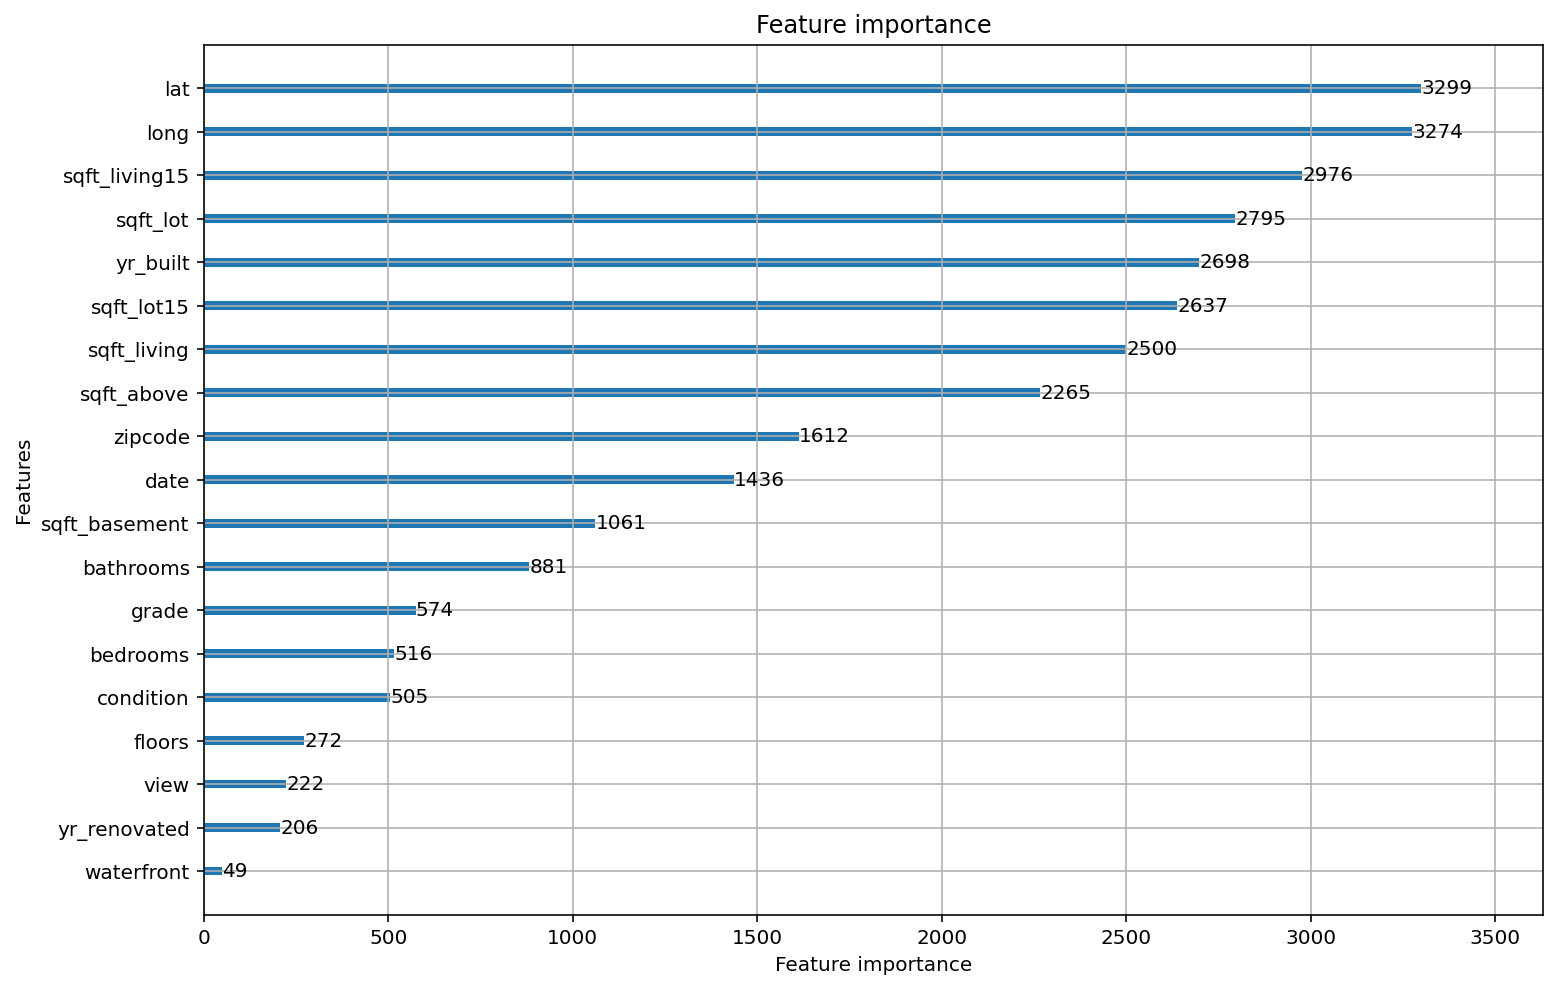

In [232]:
train = pd.read_csv(train_data_path) # csv file을 DataFrame 형태로 불러오기 
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [233]:
train.head() # train.csv dataframe 상위 5개 확인 

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [234]:
test.head() # test.csv dataframe 상위 5개 확인 

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

### 1.1. 학습 데이터에서 라벨 제거
* [del](https://www.w3schools.com/python/ref_keyword_del.asp): 메모리 비우기, 특정 칼럼 삭제 가능 
* [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html): 특정 칼럼 삭제 

In [235]:
# ## del는 두 번 수행되면 Error뜨니까 한번만 수행하고 주석 처리 해두기 
y_train_data = train['price'] # y변수에 price 컬럼을 따로 저장
del train['price'] # 저장 후 삭제 <=> 메모리 비우기 

print(train.columns)
print(len(train.columns), '개의 칼럼이 있습니다.')

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
20 개의 칼럼이 있습니다.


### 1.2. 학습 데이터와 테스트 데이터 합치기 
EDA 분석을 할 때는 학습/테스트 데이터를 함께 살펴봅니다. 하지만, 추후에 모델 학습할 때는 테스트 데이터는 학습 대상이 아니기 때문에 train_len을 통해 train set의 개수를 저장해두고 학습데이터를 불러올 수 있는 인덱스로 사용합니다. <br>
* pd.concat 사용 

In [236]:
train_len = len(train)
x_train_data = pd.concat((train, test), axis=0)

In [237]:
x_train_data.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다. <br>
### 2.1. 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

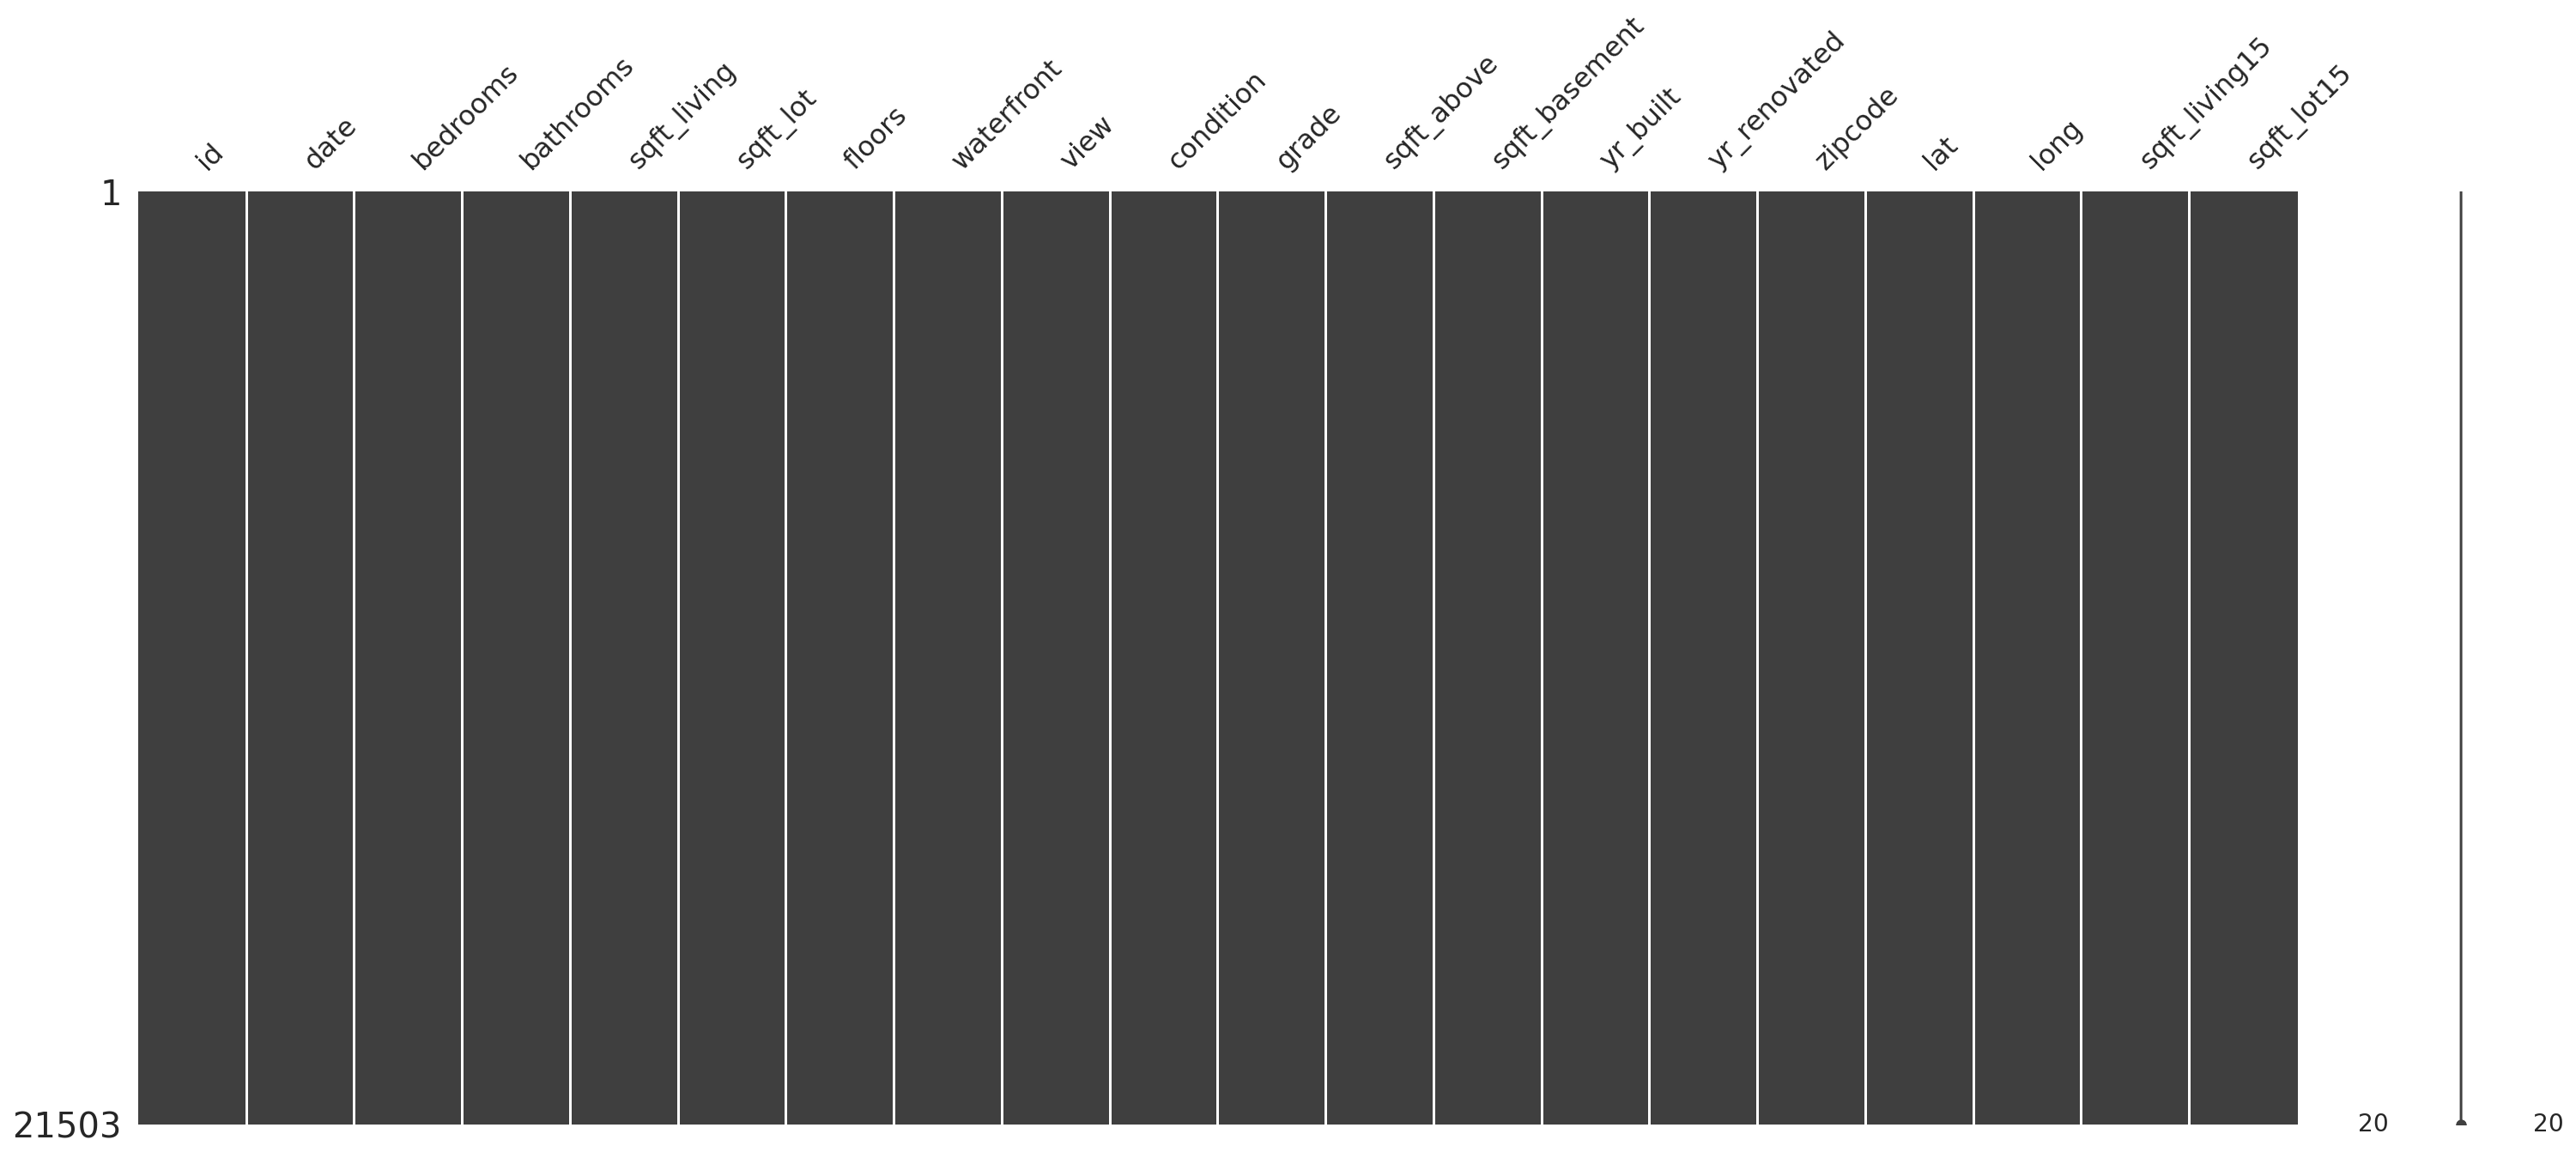

In [238]:
msno.matrix(x_train_data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>
* [DataFrame.loc](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1#loc): 인덱싱

In [239]:
for c in x_train_data.columns:
    print('{} : {}'.format(c, len(x_train_data.loc[pd.isnull(x_train_data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2.2. id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [240]:
test_id = x_train_data['id'][train_len:]
del x_train_data['id']

In [241]:
print(x_train_data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


* [apply](https://data-newbie.tistory.com/207)
* lambda: 

#### **baseline - date를 문자열 데이터로 처리: str(x[:6]** 

In [242]:
# x_train_data['date'] = x_train_data['date'].apply(lambda x : str(x[:6])) # 201410까지 슬라이싱
# x_train_data.head()

#### **baseline과 차이점 - date를 정수형 데이터로 캐스팅: .astype(int)** 
(시도) 현재 코드에서는 i:i[:6]까지만 슬라이싱 해줬으나 date별로 price 값을 시각화로 확인하거나 아니면 <br>
실험적으로 일까지 포함한 i:i[:8]까지 했을때의 결과값 차이를 확인합니다. <br>

In [243]:
x_train_data['day'] = x_train_data['date'].apply(lambda i: i[6:8]).astype(int)
x_train_data['month'] = x_train_data['date'].apply(lambda i: i[4:6]).astype(int)
x_train_data['year'] = x_train_data['date'].apply(lambda i: i[0:4]).astype(int)
x_train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  20141013T000000         3       1.00         1180      5650     1.0   
1  20150225T000000         2       1.00          770     10000     1.0   
2  20150218T000000         3       2.00         1680      8080     1.0   
3  20140627T000000         3       2.25         1715      6819     2.0   
4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  ...  yr_built  yr_renovated  zipcode  \
0           0     0          3      7  ...      1955             0    98178   
1           0     0          3      6  ...      1933             0    98028   
2           0     0          3      8  ...      1987             0    98074   
3           0     0          3      7  ...      1995             0    98003   
4           0     0          3      7  ...      1963             0    98198   

       lat     long  sqft_living15  sqft_lot15  day  month  year  
0  47.5112 -122.257           1340        5650   13     10  2014  
1  47.7379 -122.233           2720        8062   25      2  2015  
2  47.6168 -122.045           1800        7503   18      2  2015  
3  47.3097 -122.327           2238        6819   27      6  2014  
4  47.4095 -122.315           1650        9711   15      1  2015  

[5 rows x 22 columns]

In [244]:
x_train_data['date'] = x_train_data['date'].apply(lambda i: i[:8]).astype(int) # date의 년도와 월까지만 가져옴 
x_train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00         1180      5650     1.0           0   
1  20150225         2       1.00          770     10000     1.0           0   
2  20150218         3       2.00         1680      8080     1.0           0   
3  20140627         3       2.25         1715      6819     2.0           0   
4  20150115         3       1.50         1060      9711     1.0           0   

   view  condition  grade  ...  yr_built  yr_renovated  zipcode      lat  \
0     0          3      7  ...      1955             0    98178  47.5112   
1     0          3      6  ...      1933             0    98028  47.7379   
2     0          3      8  ...      1987             0    98074  47.6168   
3     0          3      7  ...      1995             0    98003  47.3097   
4     0          3      7  ...      1963             0    98198  47.4095   

      long  sqft_living15  sqft_lot15  day  month  year  
0 -122.257           1340        5650   13     10  2014  
1 -122.233           2720        8062   25      2  2015  
2 -122.045           1800        7503   18      2  2015  
3 -122.327           2238        6819   27      6  2014  
4 -122.315           1650        9711   15      1  2015  

[5 rows x 22 columns]

In [245]:
x_train_data['year'].values[1], x_train_data['month'].values[1],x_train_data['day'].values[1] # 수요일 

(2015, 2, 25)

In [246]:
datetime.date(x_train_data['year'].values[1], x_train_data['month'].values[1],x_train_data['day'].values[1]).weekday()

2

In [256]:
len(x_train_data['year']), len(x_train_data['month']), len(x_train_data['day'])

(21503, 21503, 21503)

In [257]:
datetime.date(x_train_data['year'].values[0], x_train_data['month'].values[0],x_train_data['day'].values[0]).weekday()

0

In [263]:
# 월, 화, 수, 목, 금, 토, 일 순으로 
tmp = []
for i in range(len(x_train_data['year'])):
    tmp.append(datetime.date(x_train_data['year'].values[i], x_train_data['month'].values[i],x_train_data['day'].values[i]).weekday())

x_train_data['weekday'] = tmp

In [264]:
x_train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00         1180      5650     1.0           0   
1  20150225         2       1.00          770     10000     1.0           0   
2  20150218         3       2.00         1680      8080     1.0           0   
3  20140627         3       2.25         1715      6819     2.0           0   
4  20150115         3       1.50         1060      9711     1.0           0   

   view  condition  grade  ...  yr_renovated  zipcode      lat     long  \
0     0          3      7  ...             0    98178  47.5112 -122.257   
1     0          3      6  ...             0    98028  47.7379 -122.233   
2     0          3      8  ...             0    98074  47.6168 -122.045   
3     0          3      7  ...             0    98003  47.3097 -122.327   
4     0          3      7  ...             0    98198  47.4095 -122.315   

   sqft_living15  sqft_lot15  day  month  year  weekday  
0           1340        5650   13     10  2014        0  
1           2720        8062   25      2  2015        2  
2           1800        7503   18      2  2015        2  
3           2238        6819   27      6  2014        4  
4           1650        9711   15      1  2015        3  

[5 rows x 23 columns]

### 2.3. 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.
* [seaboran.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html): 이산데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인 가능 

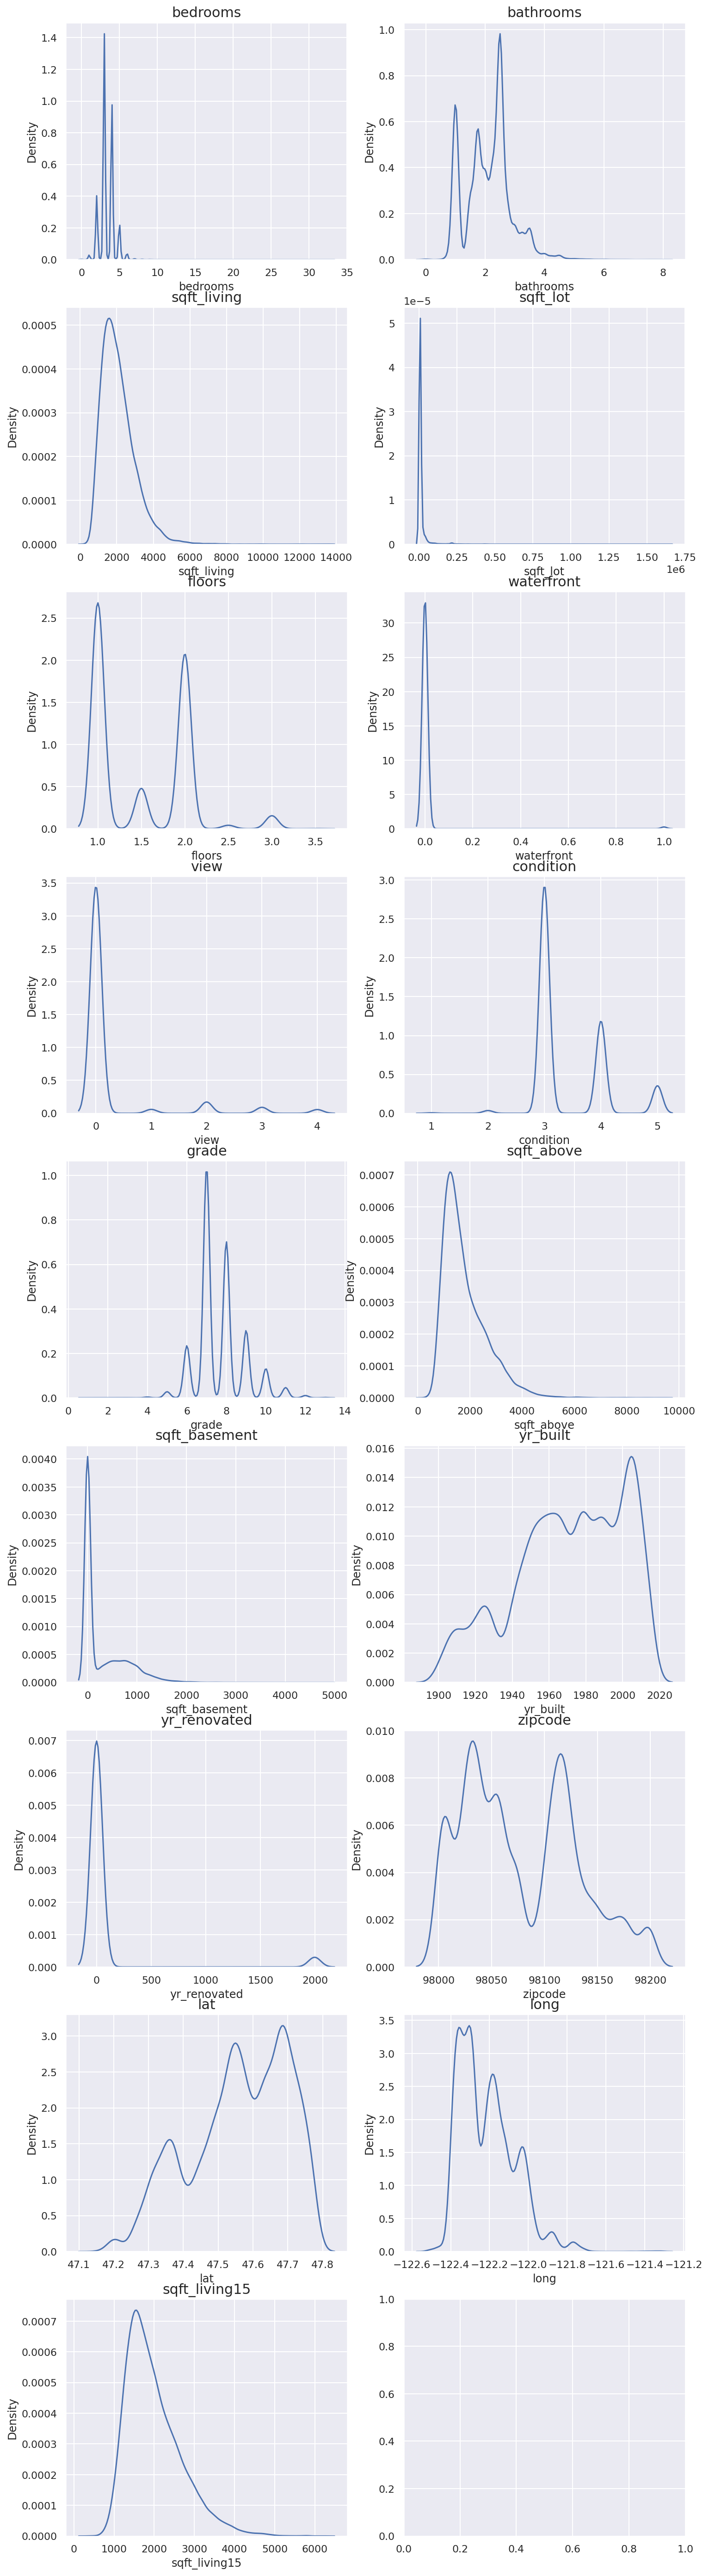

In [265]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = x_train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(x_train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

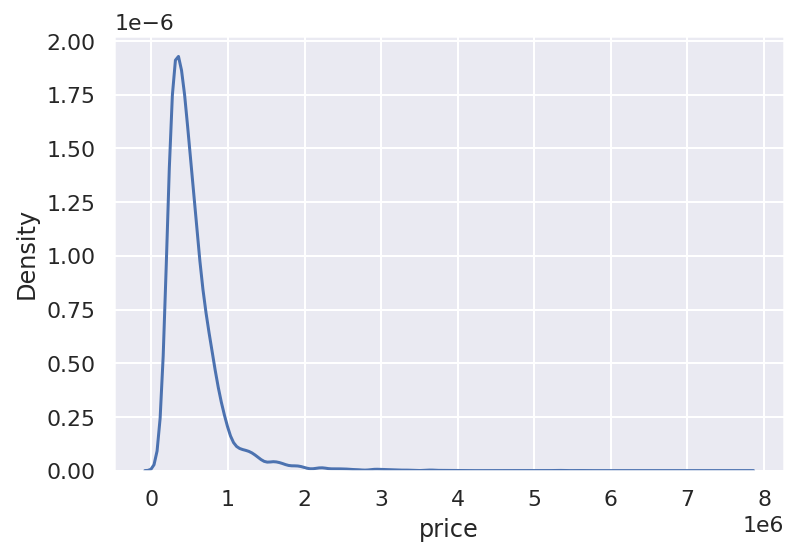

In [266]:
sns.kdeplot(y_train_data)
plt.show()

#### **baseline: 특정 카테고리만 log1p로 로그 변환**

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 등 왜도가 심한 데이터도 있지만 전체적으로 왜도가 다 심한 편입니다. <br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다. 

> log-scaling이 어떻게 치우친 분포를 정규분포로 만들 수 있을까? <br>
로그 함수는 0~1 구간에서는 기울기가 가파릅니다. 즉, x 구간이 0~1로 매우 짧고 그에 비해 y 구간은 -무한대에서 0으로 매우 큽니다. <br>
x값이 0주변에서는 가파른 기울기를 가지고, x값이 점점 커지면 기울기는 급격히 작아집니다.<br> 따라서 x가 큰 값들에서는 차이가 나지 않는 y값들을 가지는 것은 넓은 범위에서는 y값이 모이는 특성을 가지게 할 수 있다는 것입니다. <br>
그럼 치우친 경향을 보이는 그래프에 log를 씌우면? 몰려있는 데이터들이 고르게 펴지게 됩니다.반대로 너무 펴져있는 데이터들은 좀더 작은 범위안으로 모이게 됩니다.

1. 1차 시도 

(시도) 모든 컬럼에 대한 log변환 수행 <br>
(발생이슈) 전체 log를 취해주면, feature importance가 높은 long 컬럼의 내용이 없어집니다. <br>
(해결) long과 lat은 log 변환에서 제외해줘서 에러 해결할 수 있었습니다. <br>

2. 2차 시도 

(시도) long과 lat을 제외한 나머지 컬럼에 대해 모두 log 변환 수행  <br>
(결과) 생각보다 왜도를 전체 처리하고나서 metric 결과가 좋지 않았습니다. <br>

3. 3차 시도 

(시도) 왜도가 심한 특정 컬럼에 대해서만 진행해봤습니다. 전체 컬럼을 했을때 왜도보정을 거치면 정규분포스러워지는 컬럼을 대상으로 진행했습니다. <br>
(결과)


In [267]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15']

for c in skew_columns:
    x_train_data[c] = np.log1p(x_train_data[c].values)
    
# # 2차 시도. 사라졌을 때 문제가 되는 long,lat 다시 업데이트 
# # 추후 이 값으로 다시 engineering 해줄 예정입니다. 
# x_log_transformation['lat'] = x_train_data['lat']
# x_log_transformation['long'] = x_train_data['long']

#### **baseline과 차이점: 앞에서 날짜도 정수형이라 모든 카테고리 log1p로 로그 변환**
np.explm()으로 추후 모델링 값을 예측한 후에 다시 exp(x)-1 값을 반환해줄 예정입니다. 

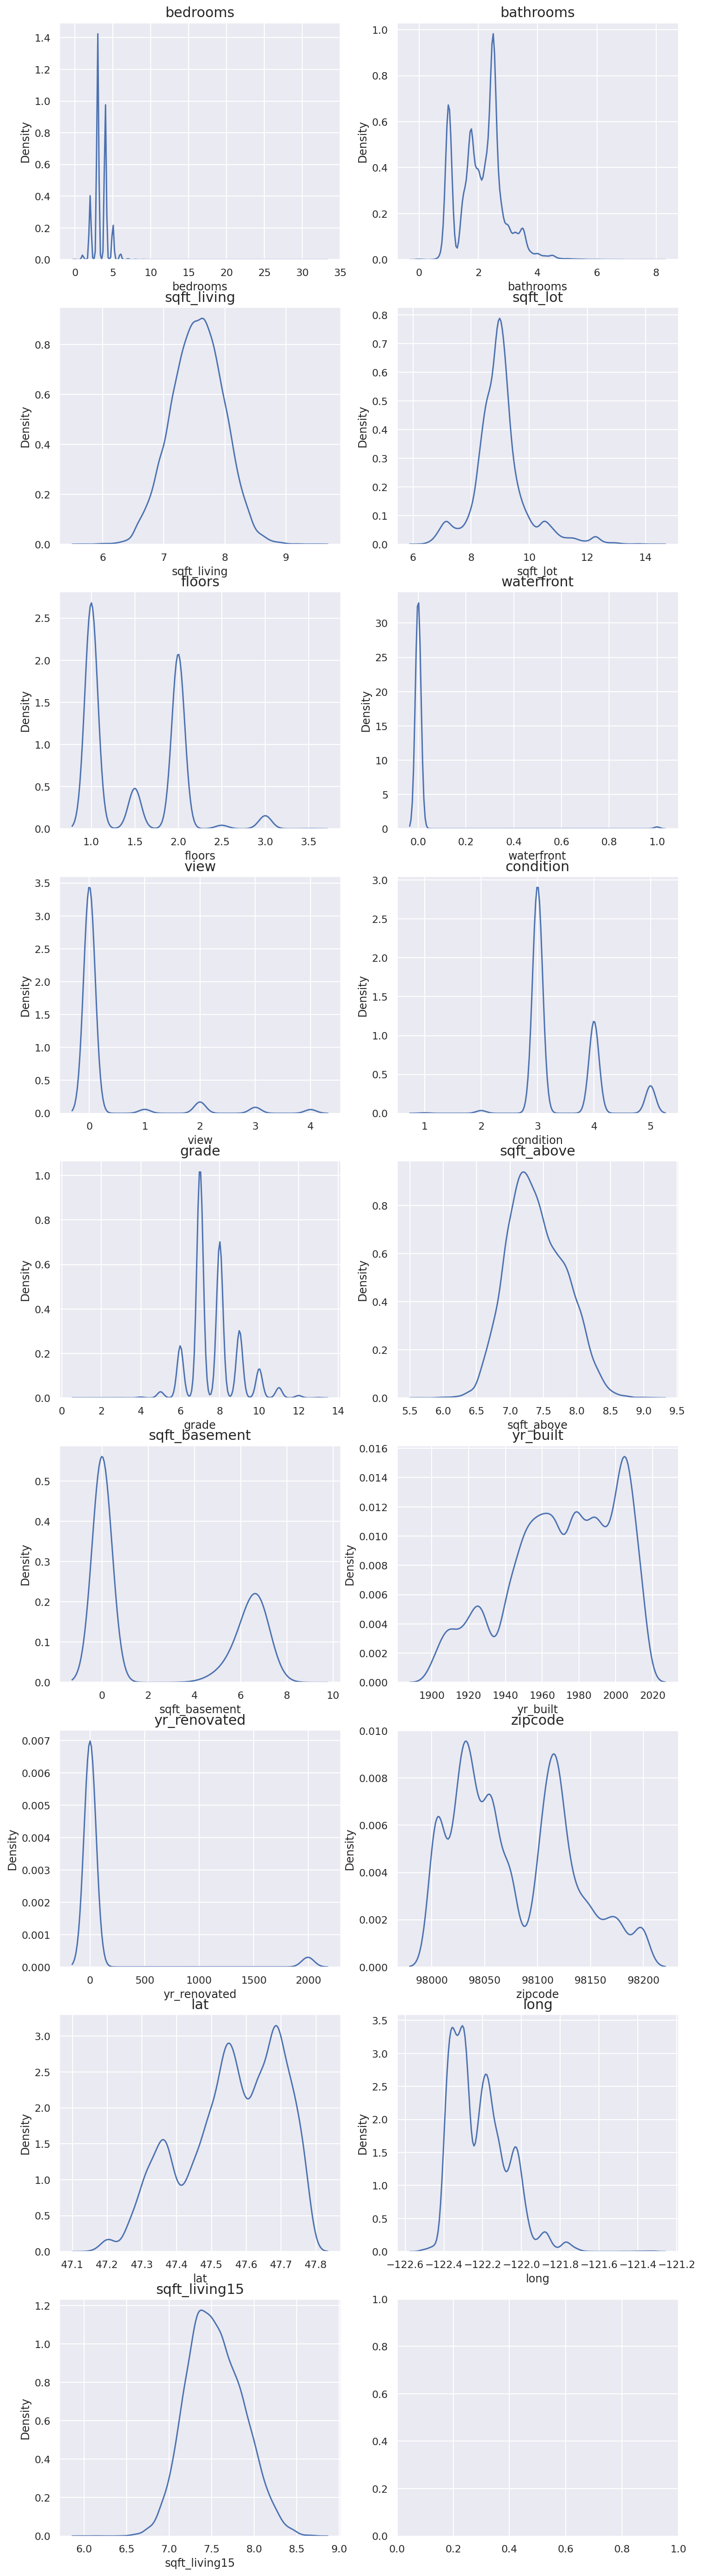

In [268]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = x_train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(x_train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다. 하지만, long과 lat과 같은 값은 주소로 변환해서 사용해줄 수 있으므로 log 변환하지 않겠습니다. <br> 

(시도) y_train에 대한 왜도 보정도 수행합니다. 
(결과) log 변환 결과로 정규분포에 더 가까워짐을 확인할 수 있었습니다.

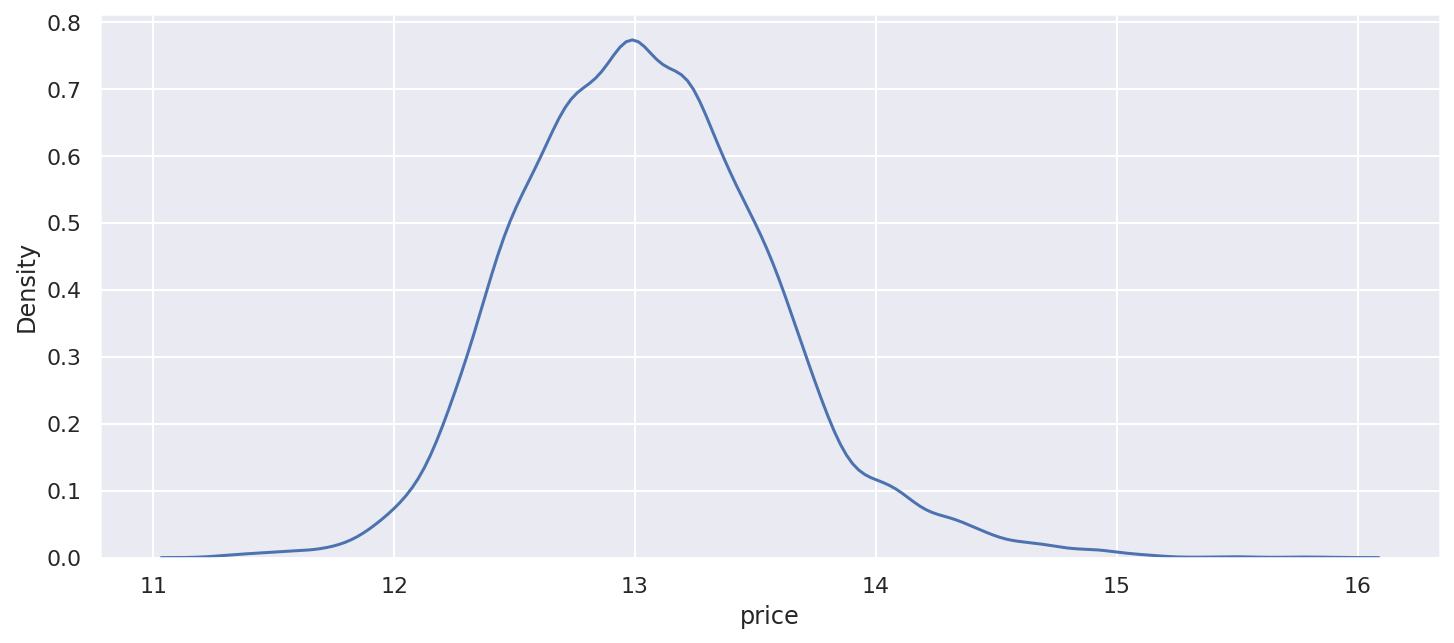

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5)) 
y_train_data = np.log1p(y_train_data)
sns.kdeplot(y_train_data)
plt.show()

1. 1차 시도 

(시도) **왜도가 심하고 baseline을 돌렸을때 feature importance가 낮게 나온, waterfront, yr_renovated, view를 제외해줍니다.** <br>
(결과) 실패, 모델의 성능이 개선되지 않았습니다. 오히려 정답률이 떨어져서 영향이 적은 인자라고 항상 drop해줌으로써 성능을 높일 수 있지 않음을 알 수 있었습니다. 

In [270]:
# pass
# x_log_transformation.drop(['yr_renovated','waterfront'], axis = 1).head()

## 시각화
히트맵과 pairplot을 통해 시각화 결과로 독립변수와 종속변수간의 상관관계를 살펴볼 수 있습니다. 이러한 결과에 따라 특성 공학을 진행할 수 있는데, 아직까지는 해당 시각화 자료를 보고 어떤 시도를 해봐야할지 결정하는 부분은 어려운거 같습니다.  

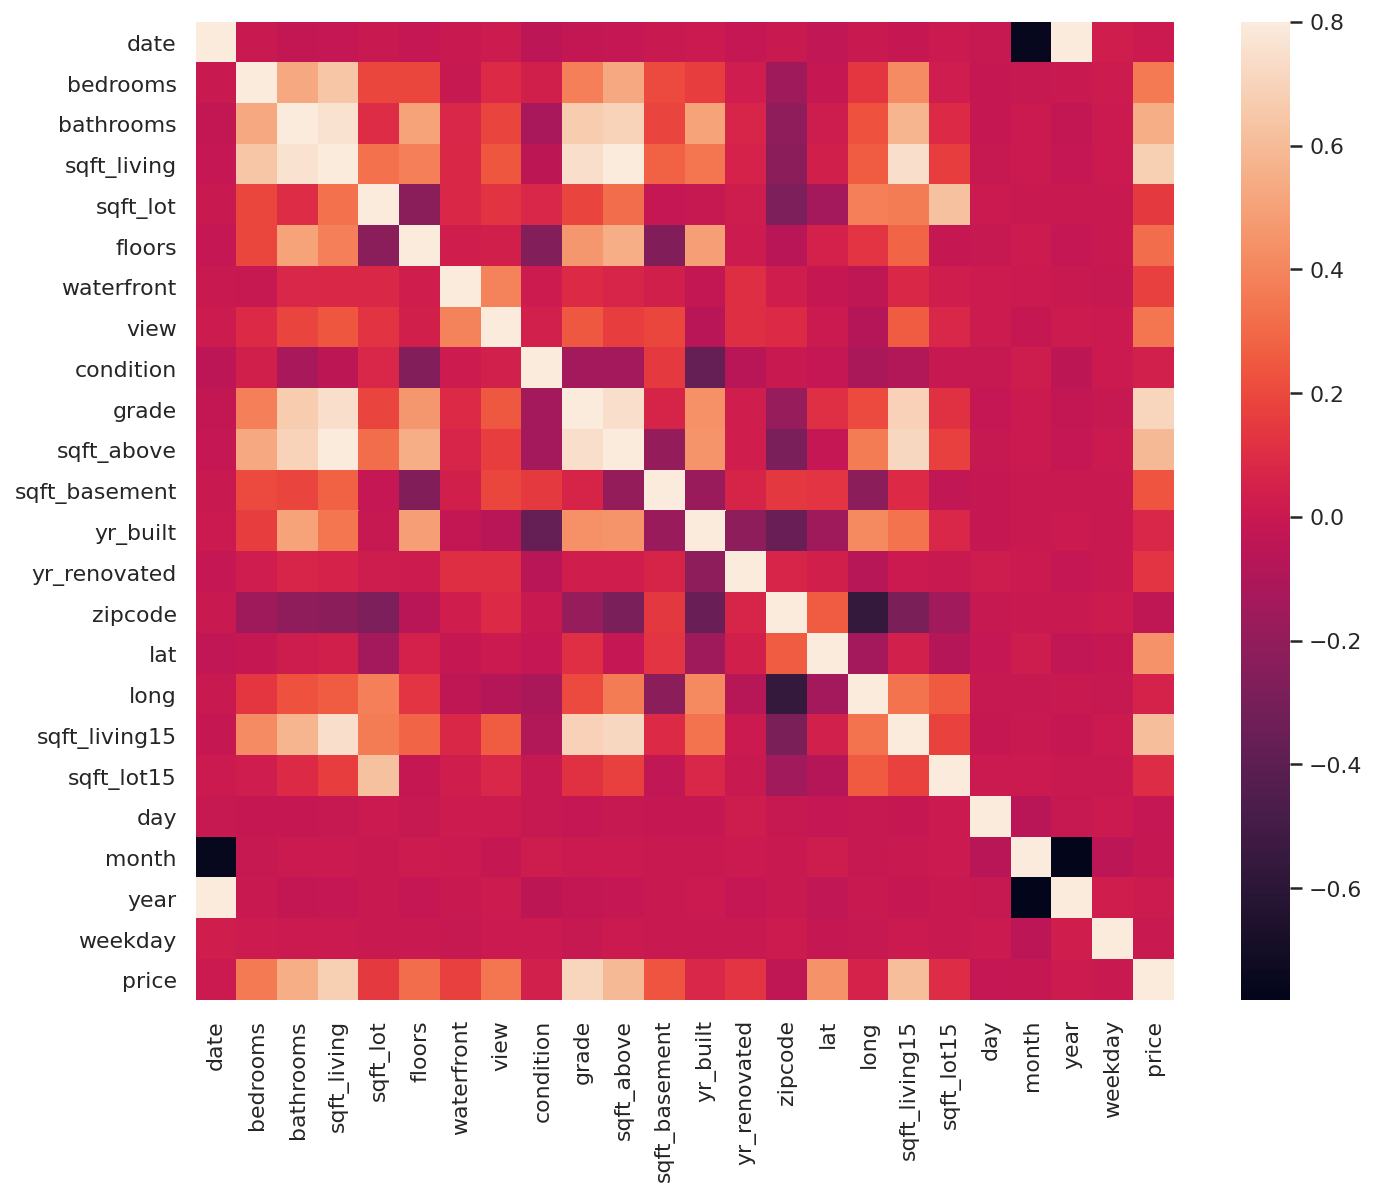

In [271]:
#correlation matrix
concat_data = pd.concat((x_train_data.iloc[:train_len, :], y_train_data), axis=1)
corrmat = concat_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [272]:
corr_matrix = concat_data.corr()
corr_matrix["price"].sort_values(ascending=False)

price            1.000000
grade            0.707412
sqft_living      0.677383
sqft_living15    0.609042
sqft_above       0.591185
bathrooms        0.552000
lat              0.444417
bedrooms         0.359946
view             0.347506
floors           0.317810
sqft_basement    0.231982
waterfront       0.172580
sqft_lot         0.145465
yr_renovated     0.127533
sqft_lot15       0.096976
yr_built         0.076293
long             0.054362
condition        0.042947
year             0.009913
date             0.009426
weekday         -0.000570
month           -0.013975
day             -0.020578
zipcode         -0.039195
Name: price, dtype: float64

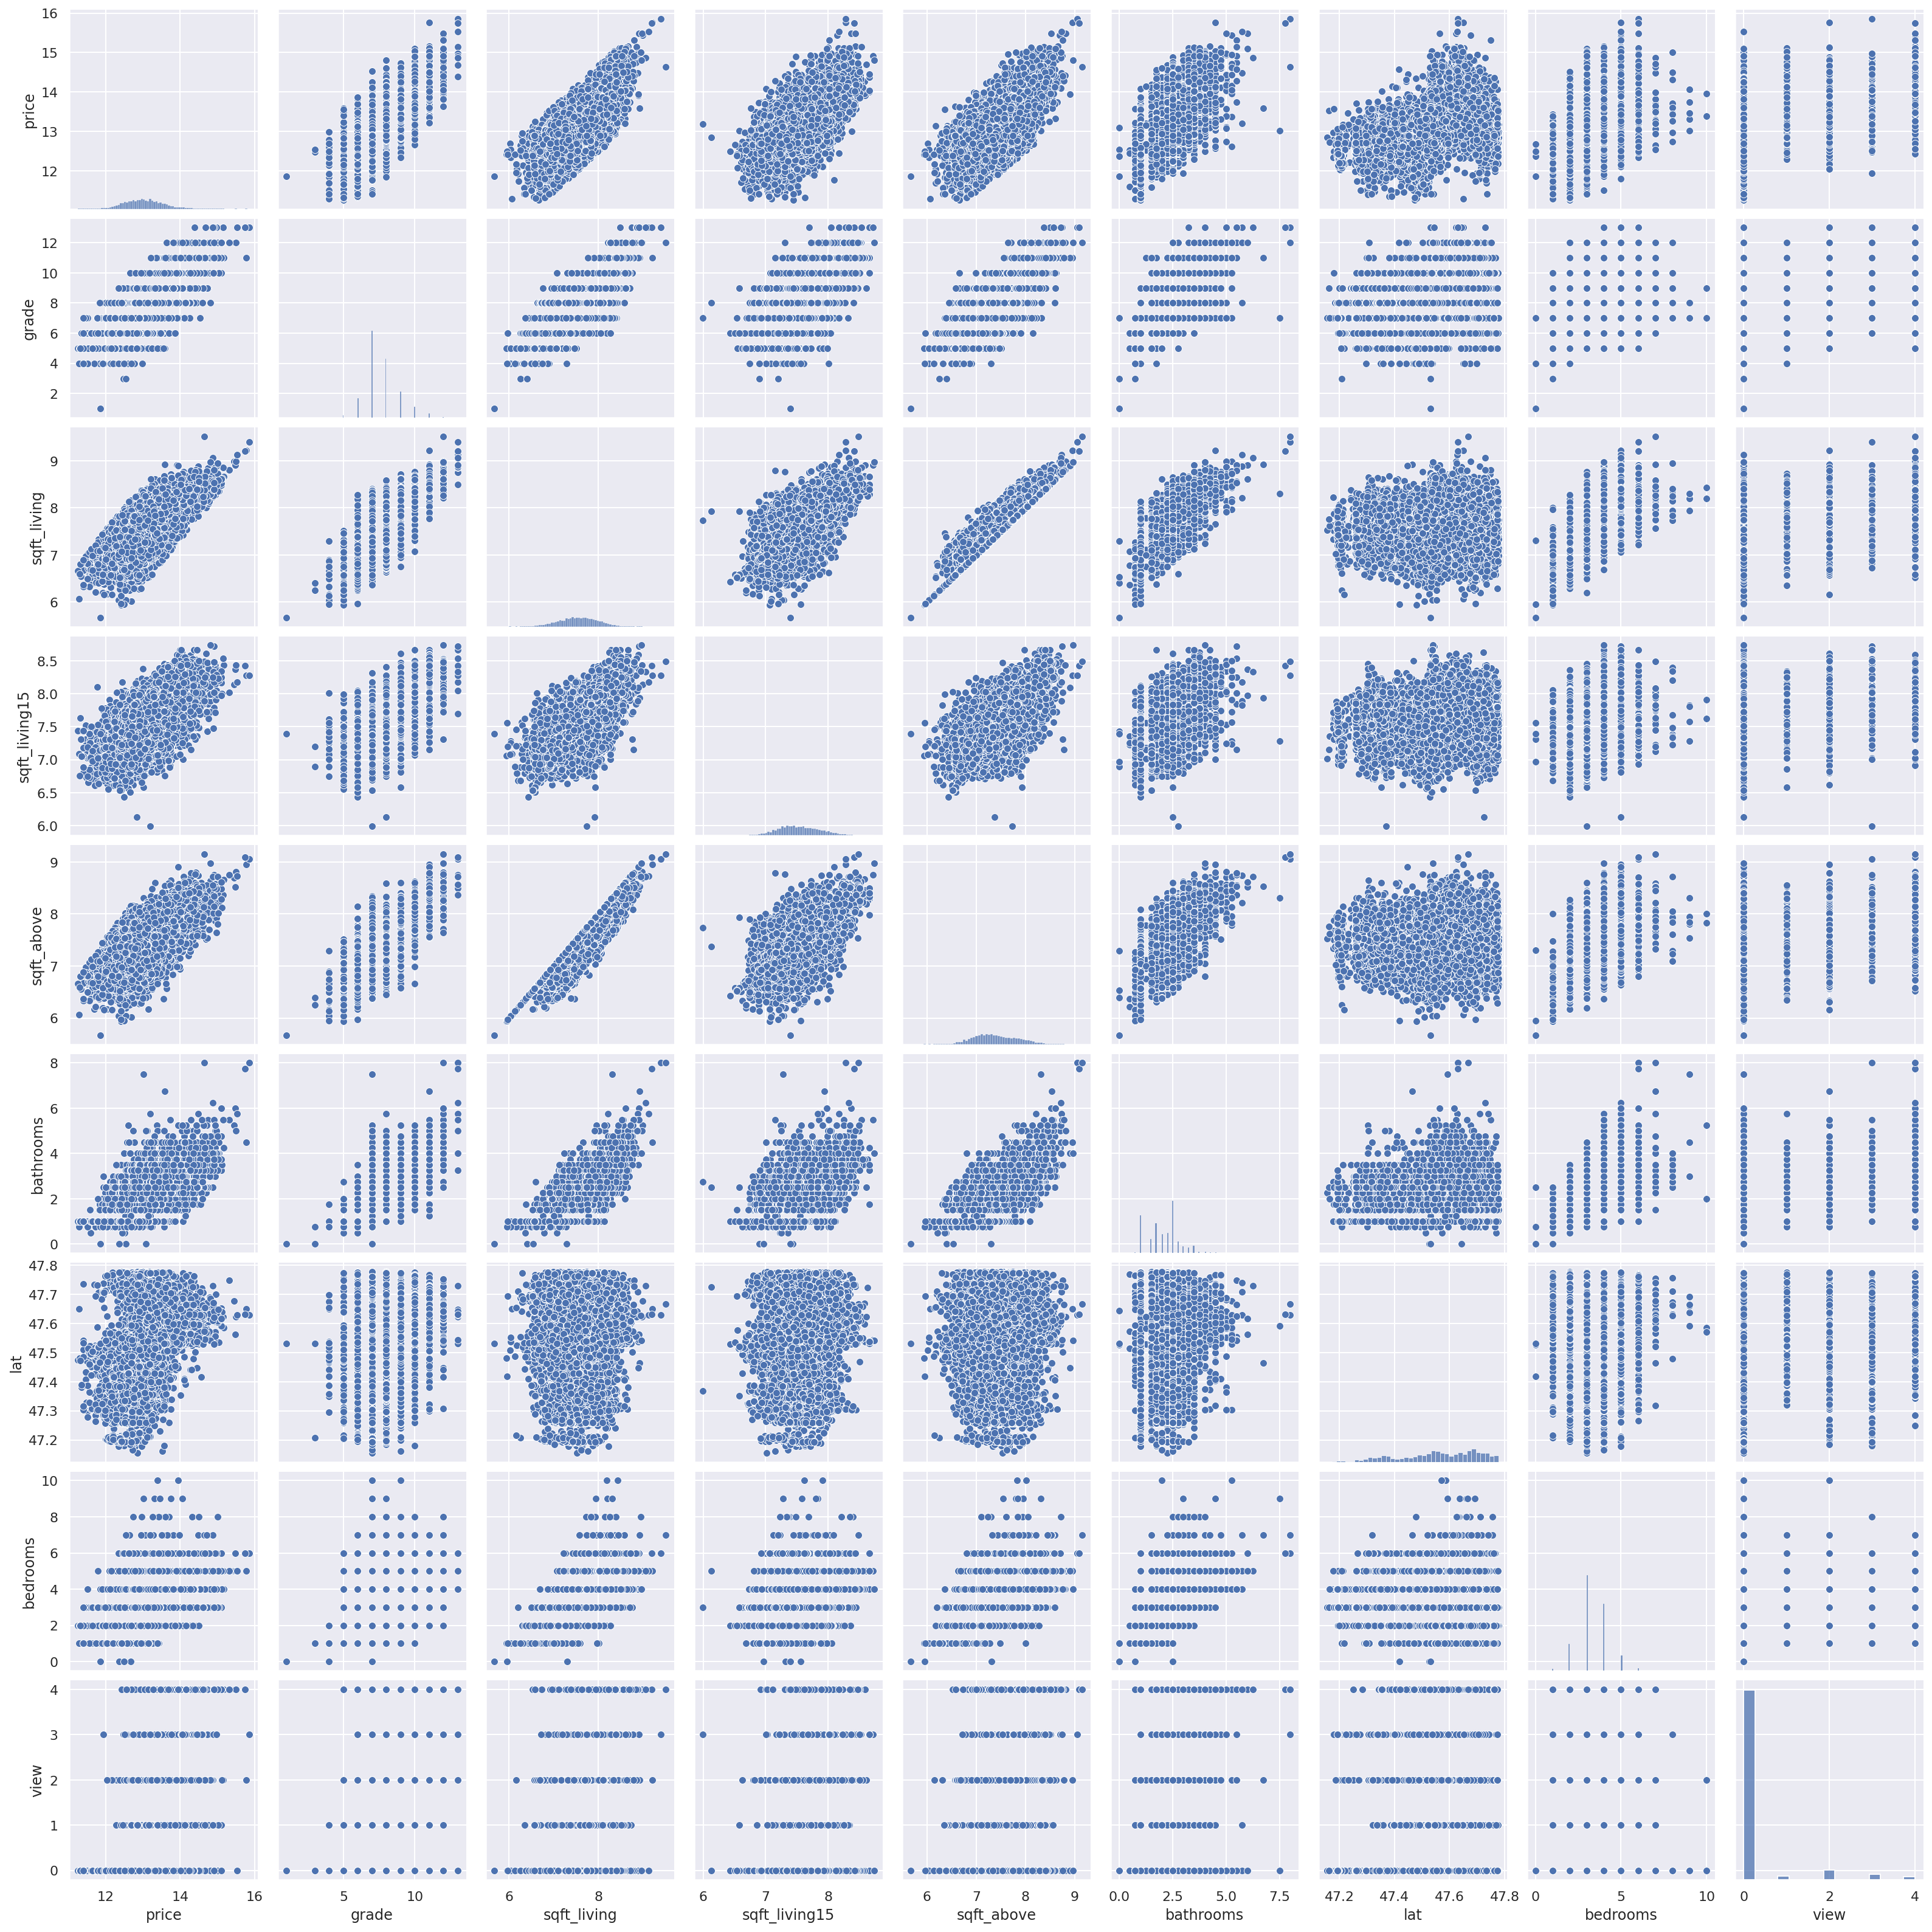

In [273]:
#scatterplot
sns.set()
cols = ['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'view']
sns.pairplot(concat_data[cols], size = 2.5)
plt.show();

이외에도 연도월별로 값을 살펴볼 수 있습니다. 

In [276]:
concat_data['date'].head()

0    20141013
1    20150225
2    20150218
3    20140627
4    20150115
Name: date, dtype: int64

<AxesSubplot:xlabel='date', ylabel='Density'>

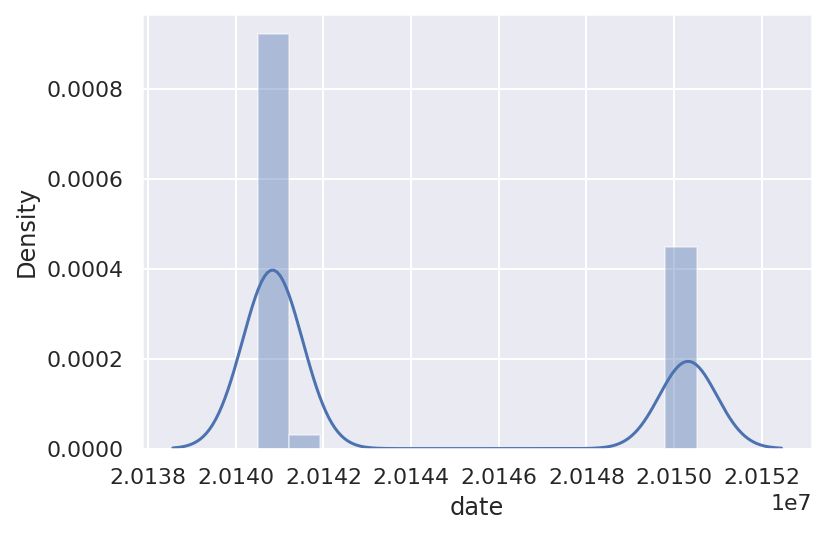

In [277]:
sns.distplot(concat_data['date'])

시각화 자료를 보면 bedrooms와 view는 이상치 제거를 해주는 편이 좋아보였습니다.

## 특성 공학 
### total_rooms 추가 
(시도) 영향력이 큰 편에 속하지 않는 bedrooms와 bathrooms를 이용해서 집의 총 방 개수를 구해봤습니다. <br>
(결과)

In [278]:
x_train_data['total_rooms'] = x_train_data['bedrooms'] + x_train_data['bathrooms']
x_train_data

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     20141013         3       1.00     7.074117  8.639588     1.0   
1     20150225         2       1.00     6.647688  9.210440     1.0   
2     20150218         3       2.00     7.427144  8.997271     1.0   
3     20140627         3       2.25     7.447751  8.827615     2.0   
4     20150115         3       1.50     6.966967  9.181118     1.0   
...        ...       ...        ...          ...       ...     ...   
6463  20140626         3       1.75     7.313887  9.390075     1.0   
6464  20150126         3       2.00     7.307202  7.027315     3.0   
6465  20150219         3       2.50     7.178545  7.166266     2.0   
6466  20140623         2       0.75     6.928538  7.208600     2.0   
6467  20150116         3       2.50     7.378384  7.778630     2.0   

      waterfront  view  condition  grade  ...  zipcode      lat     long  \
0              0     0          3      7  ...    98178  47.5112 -122.257   
1              0     0          3      6  ...    98028  47.7379 -122.233   
2              0     0          3      8  ...    98074  47.6168 -122.045   
3              0     0          3      7  ...    98003  47.3097 -122.327   
4              0     0          3      7  ...    98198  47.4095 -122.315   
...          ...   ...        ...    ...  ...      ...      ...      ...   
6463           0     0          3      6  ...    98010  47.3095 -122.002   
6464           0     0          3      8  ...    98144  47.5699 -122.288   
6465           0     0          3      8  ...    98116  47.5773 -122.409   
6466           0     0          3      7  ...    98144  47.5944 -122.299   
6467           0     0          3      8  ...    98027  47.5345 -122.069   

      sqft_living15  sqft_lot15  day  month  year  weekday  total_rooms  
0          7.201171        5650   13     10  2014        0         4.00  
1          7.908755        8062   25      2  2015        2         3.00  
2          7.496097        7503   18      2  2015        2         5.00  
3          7.713785        6819   27      6  2014        4         5.25  
4          7.409136        9711   15      1  2015        3         4.50  
...             ...         ...  ...    ...   ...      ...          ...  
6463       7.186144       11303   26      6  2014        3         4.75  
6464       7.244942        1230   26      1  2015        0         5.00  
6465       7.193686        1265   19      2  2015        3         5.50  
6466       6.928538        2007   23      6  2014        0         2.75  
6467       7.252054        1287   16      1  2015        4         5.50  

[21503 rows x 24 columns]

### ratio_sqft 추가 

In [279]:
x_train_data['ratio_sqft'] = x_train_data['sqft_living'] / x_train_data['sqft_lot']
x_train_data

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     20141013         3       1.00     7.074117  8.639588     1.0   
1     20150225         2       1.00     6.647688  9.210440     1.0   
2     20150218         3       2.00     7.427144  8.997271     1.0   
3     20140627         3       2.25     7.447751  8.827615     2.0   
4     20150115         3       1.50     6.966967  9.181118     1.0   
...        ...       ...        ...          ...       ...     ...   
6463  20140626         3       1.75     7.313887  9.390075     1.0   
6464  20150126         3       2.00     7.307202  7.027315     3.0   
6465  20150219         3       2.50     7.178545  7.166266     2.0   
6466  20140623         2       0.75     6.928538  7.208600     2.0   
6467  20150116         3       2.50     7.378384  7.778630     2.0   

      waterfront  view  condition  grade  ...      lat     long  \
0              0     0          3      7  ...  47.5112 -122.257   
1              0     0          3      6  ...  47.7379 -122.233   
2              0     0          3      8  ...  47.6168 -122.045   
3              0     0          3      7  ...  47.3097 -122.327   
4              0     0          3      7  ...  47.4095 -122.315   
...          ...   ...        ...    ...  ...      ...      ...   
6463           0     0          3      6  ...  47.3095 -122.002   
6464           0     0          3      8  ...  47.5699 -122.288   
6465           0     0          3      8  ...  47.5773 -122.409   
6466           0     0          3      7  ...  47.5944 -122.299   
6467           0     0          3      8  ...  47.5345 -122.069   

      sqft_living15  sqft_lot15  day  month  year  weekday  total_rooms  \
0          7.201171        5650   13     10  2014        0         4.00   
1          7.908755        8062   25      2  2015        2         3.00   
2          7.496097        7503   18      2  2015        2         5.00   
3          7.713785        6819   27      6  2014        4         5.25   
4          7.409136        9711   15      1  2015        3         4.50   
...             ...         ...  ...    ...   ...      ...          ...   
6463       7.186144       11303   26      6  2014        3         4.75   
6464       7.244942        1230   26      1  2015        0         5.00   
6465       7.193686        1265   19      2  2015        3         5.50   
6466       6.928538        2007   23      6  2014        0         2.75   
6467       7.252054        1287   16      1  2015        4         5.50   

      ratio_sqft  
0       0.818803  
1       0.721756  
2       0.825489  
3       0.843688  
4       0.758837  
...          ...  
6463    0.778895  
6464    1.039829  
6465    1.001714  
6466    0.961149  
6467    0.948545  

[21503 rows x 25 columns]

### total_sqft 추가 
개선되지 않아 삭제했습니다.

In [280]:
x_train_data['total_sqft'] = x_train_data['sqft_living'] + x_train_data['sqft_lot'] + x_train_data['sqft_basement'] + x_train_data['sqft_above']
del x_train_data['total_sqft']

### year, month 추가 
위쪽에서 추가 했습니다. 

---

## 3. 모델 훈련 

### 3.1. 데이터셋 분리
아까 위에서 Train len으로 저장했던 Index를 활용해서 학습데이터와 테스트 데이터를 분리해줍니다. 

#### **baseline: slicing을 통해 train과 test로 concat split => validaition set X**

In [281]:
X_test = x_train_data.iloc[train_len:, :]
x_train_data = x_train_data.iloc[:train_len, :]

print('x_train_data:', x_train_data.shape)
print('y_train_data: ',y_train_data.shape)
print('X_test: ',X_test.shape)
# y_test는 kaggle이 가지고 있다..!

x_train_data: (15035, 25)
y_train_data:  (15035,)
X_test:  (6468, 25)


In [282]:
# train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
X_train, X_val, y_train, y_val = train_test_split(x_train_data, 
                                                    y_train_data, 
                                                    random_state=random_state, 
                                                    test_size=0.1) # 0.3, 0.2, 0.1

###  3.2. 사용 모델 정의 

In [283]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#           {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]
models = [gboost, xgboost, lightgbm, rdforest]

In [284]:
gboost.__class__.__name__ # 각 모델 클래스의 내부 속성 확인

'GradientBoostingRegressor'

#### **baseline과 차이점: RMSE값 계산 함수 정의**

In [285]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### **baseline과 차이점: CV Search로 모델들의 하이퍼 파라미터 추출**
1. 1차 시도 <br>
'n_estimators': [1000, 1200, 1500],
'max_depth': [1, 10],

2. 2차 시도 <br>
'n_estimators': [800, 900, 1000, 1200, 1500],
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.05, 0.07, 1]

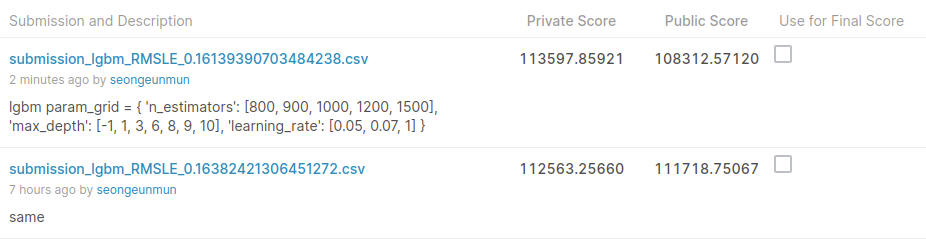
(결과) public은 높아졌지만 private이 더 낮아져버렸습니다. 과적합이 문제일까.. estimators를 줄여준 것이 원인인가 생각되어 다시 수정했습니다.

3. 3차 시도 <br>
'n_estimators': [1000, 1200, 1300, 1500],
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.05, 0.07, 1] <br>
(결과) private에서 낮아진 현상을 개선할 수 있었습니다. 

4. 4차 시도 <br>
parameter 튜닝으로는 한계가 보여서 특성공학을 시도했습니다. 몇몇 특성들을 추가해줘봤습니다. <br>
total_rooms 추가 <br>
(결과) RMSLE는 낮아지는데 private score는 113662.38928로 더 높아졌습니다... 흑.. <br>
ratio_sqft 추가 <br>
(결과) 112299.52993로 private score가 개선됬습니다!! <br>
total_sqft 추가 <br>
(결과) 113553.69837로 private score가 개선되지않아 해당 특성은 제거했습니다. 

5. 5차 시도 <br> 
'n_estimators': [1000, 1200, 1300, 1500],
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.05, 0.07, 1],
'feature_fraction': [0.8, 0.9, 1] <br>
(결과) 112838.32396로 급격하게 성능개선이 없어 default값으로 사용하겠습니다. default = 1

6. 6차 시도 <br>
'n_estimators': [1000, 1200, 1300, 1500],
<!-- #     'n_estimators': [60, 70, 80, 100, 200],     -->
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.04, 0.05, 0.07, 1],
<!-- #     'feature_fraction': [0.8, 0.9, 1], -->
    'num_leaves': [3, 6, 8, 10, 15, 20]
(결과) 111110.81258로 거의 다갔다..!!

7. 7차 시도 <br>
'n_estimators': [1000, 1200, 1300, 1500],
<!-- #     'n_estimators': [60, 70, 80, 100, 200],     -->
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.04, 0.05, 0.07, 1],
'feature_fraction': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1],
'num_leaves': [3, 6, 8, 10, 15, 20]
(결과) 110807.54874

8. N차 시도 <br> 
다시 피쳐를 건드려봤습니다. year, month로도 쪼개줘보고 했지만 흠.. 결과가 성능개선까진 이뤄지지 않았습니다. 요일에 대해 변환해보고 다시 시도해봤습니다. <br>
date가 영향력이 있기 때문에 그중에 영향력있는 값을 살펴봤을때 day가 좀더 의미가 있는 것으로 보였습니다. 요일의 영향을 받을거라는 예상은 성능.. 개선으로 이어지진 않았습니다. 

In [286]:
# 탐색할 파라미터의 종류 (딕셔너리로 입력)
param_grid = {
    'n_estimators': [1000, 1200, 1300, 1500],
#     'n_estimators': [60, 70, 80, 100, 200],    
    'max_depth': [-1, 1, 3, 6, 8, 9, 10],
    'learning_rate': [0.04, 0.05, 0.07, 1],
    'feature_fraction': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1],
    'num_leaves': [3, 6, 8, 10, 15, 20]
}

In [287]:
RandomizedSearchCV.__init__

<function sklearn.model_selection._search.RandomizedSearchCV.__init__(self, estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)>

In [288]:
random_model = RandomizedSearchCV(lightgbm, 
                                  param_distributions=param_grid, \
                                  scoring='neg_mean_squared_error', \
                                  cv=5, 
                                  verbose=2,
                                  n_jobs=5
                                 )

random_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=30)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    8.2s finished


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=3854), n_jobs=5,
                   param_distributions={'feature_fraction': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.7, 1],
                                        'learning_rate': [0.04, 0.05, 0.07, 1],
                                        'max_depth': [-1, 1, 3, 6, 8, 9, 10],
                                        'n_estimators': [1000, 1200, 1300,
                                                         1500],
                                        'num_leaves': [3, 6, 8, 10, 15, 20]},
                   scoring='neg_mean_squared_error', verbose=2)

In [289]:
params = random_model.cv_results_['params']
score = random_model.cv_results_['mean_test_score']

In [290]:
results = pd.DataFrame(params)
results['score'] = score

results

num_leaves  n_estimators  max_depth  learning_rate  feature_fraction  \
0           3          1300          3           0.07               0.2   
1           8          1500          3           0.05               0.1   
2          10          1300          6           0.05               1.0   
3          10          1000         -1           0.04               0.5   
4          10          1000         10           0.04               0.1   
5           6          1300         10           1.00               0.4   
6           8          1500          6           0.04               0.4   
7           6          1500         10           0.04               0.3   
8           8          1200          1           0.05               0.5   
9          15          1000         -1           0.07               0.7   

      score  
0 -0.030069  
1 -0.028557  
2 -0.026385  
3 -0.026462  
4 -0.029041  
5 -0.036016  
6 -0.026598  
7 -0.027103  
8 -0.038035  
9 -0.026477

In [291]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

num_leaves  n_estimators  max_depth  learning_rate  feature_fraction  \
0           3          1300          3           0.07               0.2   
1           8          1500          3           0.05               0.1   
2          10          1300          6           0.05               1.0   
3          10          1000         -1           0.04               0.5   
4          10          1000         10           0.04               0.1   
5           6          1300         10           1.00               0.4   
6           8          1500          6           0.04               0.4   
7           6          1500         10           0.04               0.3   
8           8          1200          1           0.05               0.5   
9          15          1000         -1           0.07               0.7   

      score      RMSE  
0 -0.030069  0.173403  
1 -0.028557  0.168989  
2 -0.026385  0.162436  
3 -0.026462  0.162671  
4 -0.029041  0.170414  
5 -0.036016  0.189778  
6 -0.026598  0.163089  
7 -0.027103  0.164630  
8 -0.038035  0.195025  
9 -0.026477  0.162716

In [292]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

num_leaves  n_estimators  max_depth  learning_rate  feature_fraction  \
0           3          1300          3           0.07               0.2   
1           8          1500          3           0.05               0.1   
2          10          1300          6           0.05               1.0   
3          10          1000         -1           0.04               0.5   
4          10          1000         10           0.04               0.1   
5           6          1300         10           1.00               0.4   
6           8          1500          6           0.04               0.4   
7           6          1500         10           0.04               0.3   
8           8          1200          1           0.05               0.5   
9          15          1000         -1           0.07               0.7   

      score     RMSLE  
0 -0.030069  0.173403  
1 -0.028557  0.168989  
2 -0.026385  0.162436  
3 -0.026462  0.162671  
4 -0.029041  0.170414  
5 -0.036016  0.189778  
6 -0.026598  0.163089  
7 -0.027103  0.164630  
8 -0.038035  0.195025  
9 -0.026477  0.162716

In [293]:
results = results.sort_values('RMSLE')
results

num_leaves  n_estimators  max_depth  learning_rate  feature_fraction  \
2          10          1300          6           0.05               1.0   
3          10          1000         -1           0.04               0.5   
9          15          1000         -1           0.07               0.7   
6           8          1500          6           0.04               0.4   
7           6          1500         10           0.04               0.3   
1           8          1500          3           0.05               0.1   
4          10          1000         10           0.04               0.1   
0           3          1300          3           0.07               0.2   
5           6          1300         10           1.00               0.4   
8           8          1200          1           0.05               0.5   

      score     RMSLE  
2 -0.026385  0.162436  
3 -0.026462  0.162671  
9 -0.026477  0.162716  
6 -0.026598  0.163089  
7 -0.027103  0.164630  
1 -0.028557  0.168989  
4 -0.029041  0.170414  
0 -0.030069  0.173403  
5 -0.036016  0.189778  
8 -0.038035  0.195025

In [294]:
rmsle_value = results['RMSLE'].min()
rmsle_value

0.16243597068816815

(오류 해결) 아예 값이 같을 때 배열이 2개를 가져오는 경우가 있어서 첫번째 인자로 지정해줬습니다. 

In [295]:
hyper_n = results[results['RMSLE'] == rmsle_value]['n_estimators'].values[0]
hyper_n

1300

In [296]:
hyper_depth = results[results['RMSLE'] == rmsle_value]['max_depth'].values[0]
hyper_lr  = float(results[results['RMSLE'] == rmsle_value]['learning_rate'].values[0])
hyper_frac = float(results[results['RMSLE'] == rmsle_value]['feature_fraction'].values[0])
hyper_leaves = results[results['RMSLE'] == rmsle_value]['num_leaves'].values[0]

In [297]:
model = lgb.LGBMRegressor(max_depth=hyper_depth, n_estimators=hyper_n, learning_rate = hyper_lr, \
                          feature_fraction = hyper_frac,
                          random_state=random_state,
                         num_leaves = hyper_leaves)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
prediction

array([13.13413578, 13.06371078, 14.24839226, ..., 13.04831723,
       12.71351101, 12.99056868])

In [298]:
prediction = np.expm1(prediction)
len(prediction)

6468

---

#### **baseline과 차이점: validation set을 활용해서 rmse값을 기준으로 모델의 예측 결과 비교**

In [299]:
# def get_scores(models, X_train, X_val, y_train, y_val):
#     df = {}

#     for model in models:
#         # 모델 클래스의 내부 속성에서 이름 확보
#         model_name = model.__class__.__name__

#         # 모델 학습
#         model.fit(X_train, y_train)

#         # 예측
#         y_pred = model.predict(X_val)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = rmse(y_val, y_pred)

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
#     return score_df

# get_scores(models, X_train, X_val, y_train, y_val)

### 3.2. Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

#### **✓baseline: validation set을 k-fold(k = 5)로 각 모델들의 성능을 확인**
k-fold validation한 결과를 np.mean으로 평균을 내서 각 모델들의 성능을 검증합니다. 

In [300]:
# def get_cv_score(models):
#     kfold = KFold(n_splits=5, random_state=2020).get_n_splits(x_train.values)
#     for model in models:
#         print("Model {} CV score : {:.4f}".format(model['name'], np.mean(cross_val_score(model['model'], x_train.values, y_train)), 
#                                              kf=kfold))

In [301]:
# get_cv_score(models)

#### **✓baseline과 차이점: 위에서 Validation을 Train의 10%로 Split 해주는 것으로 대체**
k-fold 방식은 Train set을 다섯등분해서 1/5씩 5회 돌아가면서 Validation set으로 활용하는 방법입니다. 이 방법은 연산량이 매우 많다는 단점이 있습니다. 한 데이터셋의 5배만큼 연산이 이뤄지는 거니까요 

### 3.3. Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.<br>
* [결정계수(R Squared)](https://newsight.tistory.com/259)

#### ✓Average Blending

In [302]:
# def AveragingBlending(models, x_train, y_train, x_test):
#     for model in models : 
#         model['model'].fit(x_train.values, y_train)
    
#     predictions = np.column_stack([
#         model['model'].predict(x_test.values) for model in models
#     ])
#     return np.mean(predictions, axis=1)

# print('💢')

In [303]:
# y_pred = AveragingBlending(models, x_train, y_train, x_test)
# print(len(y_pred))
# y_pred

## 제출

In [304]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
# submission.head()
len(submission)

6468

In [305]:
submission['price'] = prediction
submission.head()

id         price
0  15035  5.059200e+05
1  15036  4.715162e+05
2  15037  1.541693e+06
3  15038  2.936908e+05
4  15039  3.244984e+05

In [306]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', rmsle_value)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.16243597068816815.csv


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

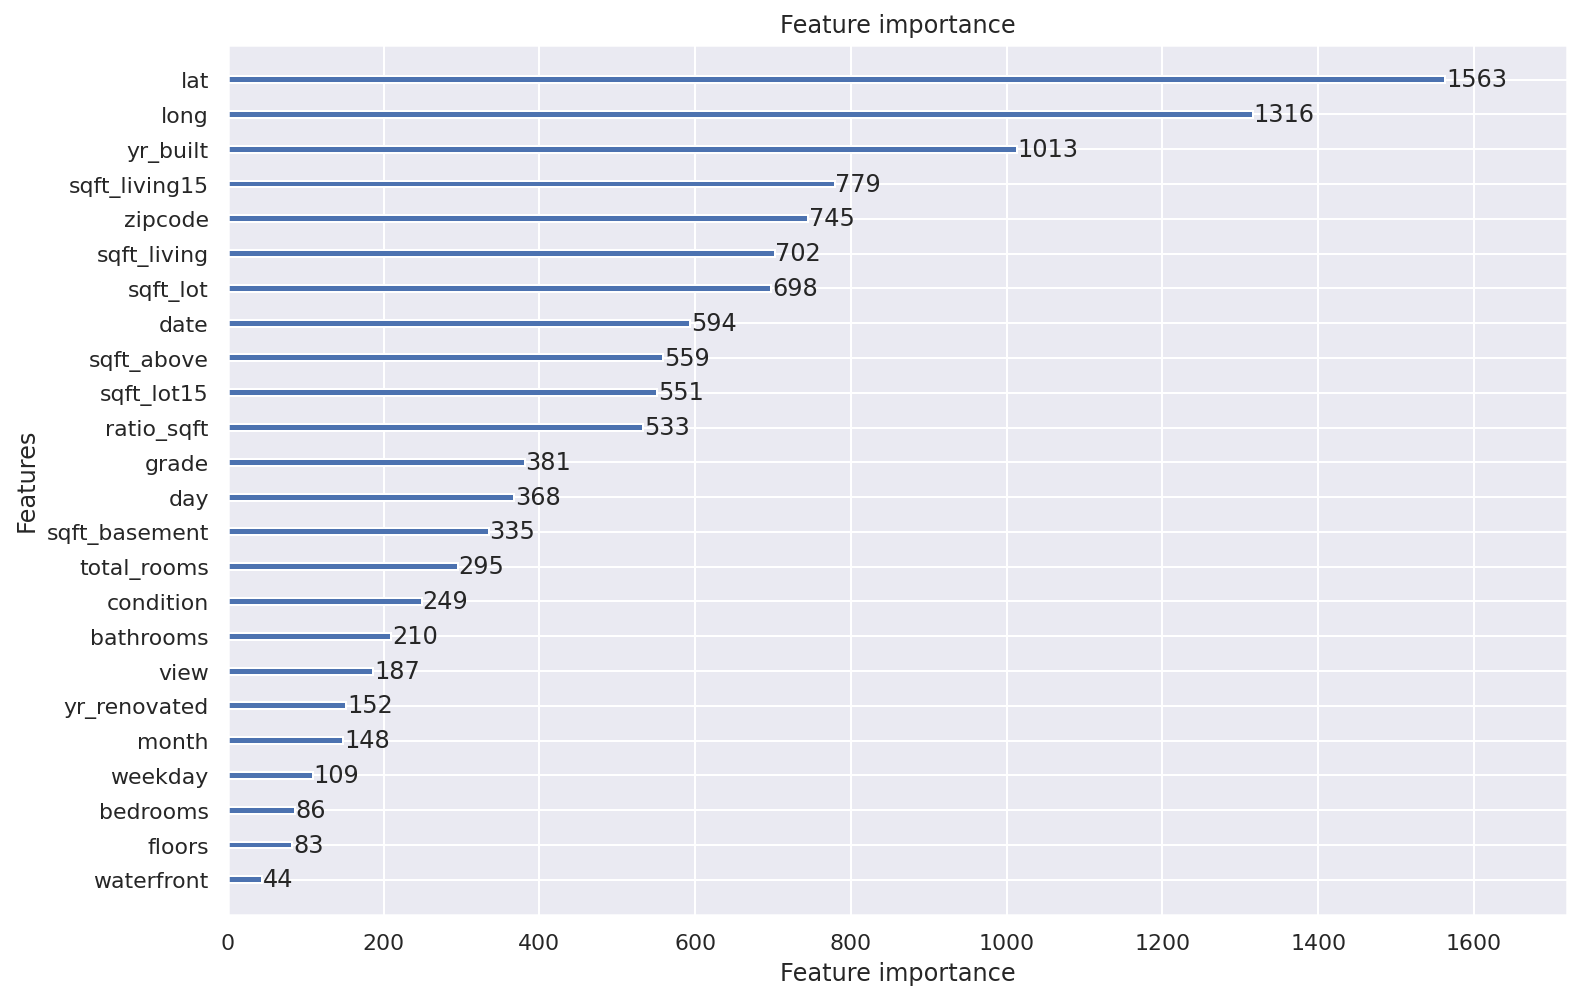

In [307]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
lgb.plot_importance(model, ax = ax)

## 루브릭 
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가? 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다. <br>
* 데이터 전처리 
* 특성 공학 
* 교차 검증 - Random Search 
* 모델 학습 - XGBoost, LGBM Regressor 
* 예측 

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가? 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  <br>
* 이해를 돕도록 추가 코드와 baseline과의 차이점에 대해 각 시도, 결과와 매칭하여 서술했습니다. 

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가? 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.  <br>
* LGBM Regressor - 110807.54874점 정도의 점수를 얻었습니다. 

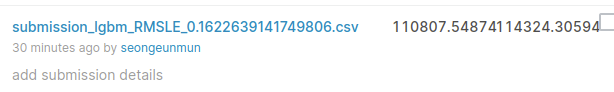

## 회고

### Hyper-parameter  - lightGBM/ XGBoost 
ensemble과 같은 경우 구조자체가 파라미터에 맞게 맞춰져 그다지 정확도면에서 차이가 없을 수 있다고 합니다. 따라서 각 모델들의 파라미터를 블로그에 나온 우선순위를 위주로 파라미터를 정리해봤습니다. <br>
* 참고 링크: http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/ <br>

1. 예측력에 큰 영향을 주는 파라미터(먼저, 최적 파라미터 찾기) 
* learning rate/ eta
    * 주로 0.05~0.1 정도로 맞추고 그 이상이면 다른 파라미터를 튜닝할때 미세하게 조정하고 싶으면 더 작게 두기도하나, 한번 다른 파라미터를 고정하면 바꿀 필요는 없습니다. 
    * 굳이 긴 소수점으로 튜닝할 필요없습니다. 
* num_iterations/ nrounds
    * 너무 크게하면 오버피팅 되나, early_stoping을 설정해주면 크게 줘도 오버피팅을 방지할 수 있다. 
    * lightgbm default = 100이나 너무 적으므로 일반적으로 1000이상의 값을 줍니다. 
* early_stopping_round/ early_stopping_rounds
    * valid set이 있을 때 사용하며, valid set이 정해진 수만큼 발전 없으면 그만두게 설정합니다. 
* max_depth 
    * feature 개수가 많을수록 높게 설정합니다. 
    * 파라미터 설정시 제일 먼저 설정합니다. 
    * default max_depth = -1이고 무제한 분기를 의미합니다. 

2. 일반적인 값을 사용하는 파라미터(일반적인 파라미터값을 사용 or 이후 세부적인 튜닝)
* feature_fraction/ colsample_bytree
    * default feature_fraction = 1입니다. 
    * 0.7~0.9로 주로 세팅하는 편이다. 
* scale_pos_weight
    * 데이터셋의 불균형이 심할 때 1.1~1.5로 조정합니다. 
    * 이외의 상황에선 주로 default scale_pos_weight = 1입니다. 
    
3. 주의가 필요한 파라미터(default로 사용) 
* bagging_fraction/ subsample
* lambda_l1/ alpha
* lambda_l2/ lambda
* max_bin

### Feature Engineering에서 느낀 부족한 점 
시각화를 하고, 그 결과를 따라 변수간의 관계를 파악할 줄 알아야하는데, 아직까지는 직관에 의해 특성을 추가하는 정도만 하고 있어서 부족하다고 느껴졌습니다. 시각화에 대해 어떻게 결과를 분석하고 판단할지를 추후에 연습해볼 예정입니다. 
### 어려웠던 점 
11만점의 벽을 넘지 못 하면서, 튜닝과 특성을 수정하는 시도를 했음에도.. 불구하고.. 아쉬움이 남는 프로젝트였습니다. <br>

### 추가로 시도해볼 점 
좀 더 많은 특성을 추가해봄으로써 성능개선에 대해 더 시도해볼 예정입니다. 